In [ ]:
%tensorflow_version 2.x

#!pip install tf-nightly-gpu
import tensorflow as tf
print(tf.__version__)

# Test if GPU is active
device_name = tf.test.gpu_device_name()
device_name

2.2.0-rc2


'/device:GPU:0'

In [ ]:
#useful link https://towardsdatascience.com/generating-modern-arts-using-generative-adversarial-network-gan-on-spell-39f67f83c7b4
#TODO da rifare tutto il model e il train. Guarda https://www.tensorflow.org/tutorials/generative/dcgan

In [ ]:
# Download the dataset
!git clone https://github.com/AlessioGalluccio/GANguya

Cloning into 'GANguya'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [ ]:
!unzip /content/GANguya/Miko_minimal.zip

Archive:  /content/GANguya/Miko_minimal.zip
  inflating: Miko_Minimal/Miko0.png  
  inflating: Miko_Minimal/Miko1.png  
 extracting: Miko_Minimal/Miko10.png  
 extracting: Miko_Minimal/Miko100.png  
  inflating: Miko_Minimal/Miko101.png  
  inflating: Miko_Minimal/Miko102.png  
  inflating: Miko_Minimal/Miko103.png  
 extracting: Miko_Minimal/Miko104.png  
  inflating: Miko_Minimal/Miko105.png  
  inflating: Miko_Minimal/Miko106.png  
 extracting: Miko_Minimal/Miko107.png  
 extracting: Miko_Minimal/Miko108.png  
  inflating: Miko_Minimal/Miko109.png  
  inflating: Miko_Minimal/Miko11.png  
 extracting: Miko_Minimal/Miko110.png  
  inflating: Miko_Minimal/Miko111.png  
  inflating: Miko_Minimal/Miko112.png  
  inflating: Miko_Minimal/Miko113.png  
 extracting: Miko_Minimal/Miko114.png  
 extracting: Miko_Minimal/Miko115.png  
  inflating: Miko_Minimal/Miko116.png  
  inflating: Miko_Minimal/Miko117.png  
 extracting: Miko_Minimal/Miko118.png  
 extracting: Miko_Minimal/Miko119.png  
 e

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
#from glob import glob                                                           
#import cv2 
#pngs = glob('./**/*.png', recursive=True)

#for j in pngs:
 #   img = cv2.imread(j)
  #  cv2.imwrite(j[:-3] + 'jpg', img)

In [ ]:
#import os
#for file in os.listdir('/content/Miko'):
 # if file.endswith('.png'):
  #  os.remove(file)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 1 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 4

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/Miko_Minimal'
EPOCHS = 15000
BATCH_SIZE = 64
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 32px square images.


# Loading data and Pre-processing

In [ ]:
# Image set has 11,682 images.  Can take over an hour for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = DATA_PATH
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  #print("Saving training image binary...")
  #np.save(training_binary_path,training_data)
  #elapsed = time.time()-start
  #print (f'Image preprocess time: {hms_string(elapsed)}')
#else:
 # print("Loading previous training pickle...")
  #training_data = np.load(training_binary_path)

 29%|██▉       | 40/139 [00:00<00:00, 398.85it/s]

Looking for file: /content/Miko_Minimal/training_data_32_32.npy
Loading training images...


100%|██████████| 139/139 [00:00<00:00, 670.57it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


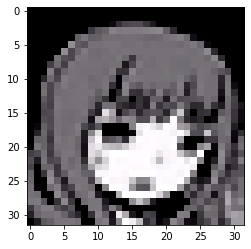

In [ ]:
#show one pre-processed image
plt.imshow(training_data[100])

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Model

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

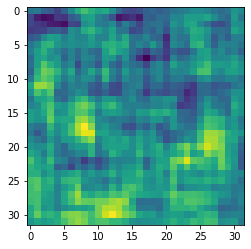

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50041]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-5,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-5,0.5)

# Training

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')


# Run code

In [ ]:
train(train_dataset, EPOCHS)

Streaming output truncated to the last 5000 lines.
Epoch 10003, gen loss=0.6876913905143738,disc loss=1.0155582427978516, 0:00:00.06
Epoch 10004, gen loss=0.6879231333732605,disc loss=1.0169183015823364, 0:00:00.06
Epoch 10005, gen loss=0.6887898445129395,disc loss=1.0184017419815063, 0:00:00.06
Epoch 10006, gen loss=0.6874540448188782,disc loss=1.018081784248352, 0:00:00.06
Epoch 10007, gen loss=0.6894542574882507,disc loss=1.0135999917984009, 0:00:00.06
Epoch 10008, gen loss=0.6882807612419128,disc loss=1.0165141820907593, 0:00:00.06
Epoch 10009, gen loss=0.6910973191261292,disc loss=1.017110824584961, 0:00:00.06
Epoch 10010, gen loss=0.6882216334342957,disc loss=1.0150145292282104, 0:00:00.06
Epoch 10011, gen loss=0.6856300830841064,disc loss=1.0277706384658813, 0:00:00.06
Epoch 10012, gen loss=0.689592182636261,disc loss=1.012776255607605, 0:00:00.06
Epoch 10013, gen loss=0.6868693232536316,disc loss=1.0269752740859985, 0:00:00.06
Epoch 10014, gen loss=0.687164306640625,disc loss=1